## Eco Region Statistics

### This notebook is to calculate the area of each ecoregion covered by different hazards and asset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import util

In [3]:
#path to clean data folder
clean_data = "../data/clean/"
raw_data = "../data/raw/"

In [4]:
## Read in data ###
# CA EPA eco regions
ecoregions = gpd.read_file(clean_data + "soco_ecoregion_l4/soco_ecoregion_l4.shp") 

# read in hazard data
flood_plains = gpd.read_file(clean_data + "flood_awareness_areas/flood_awareness_areas.shp")
wildfire_risk = gpd.read_file(clean_data + "soco_wildfire_risk_index/Wildfire_Risk_Index.shp")
slr_75 = gpd.read_file(clean_data + "fldhazd_slr75_w000/all_fldhazd_slr75_w000.shp")
slr_75_100 = gpd.read_file(clean_data + "fldhazd_slr75_w100/all_fldhazd_slr75_w100.shp")
slr_200 = gpd.read_file(clean_data + "fldhazd_slr200_w000/all_fldhazd_slr200_w000.shp")
ls_risk = gpd.read_file(clean_data + "soco_landslide_risk/ls_risk.shp")

# read in assets data
sonoma_veg_simp = gpd.read_file(clean_data + "sonoma_veg/sonoma_veg.shp")
landuse = gpd.read_file(raw_data + "soco_landuse/soco_landuse.shp") 
critical_facilities = gpd.read_file(raw_data + "soco_critical_facilities/critical_facilities.shp")

# Boundaries
soco_bound = gpd.read_file(clean_data + "sonoma_county_boundary/sonoma_county_boundary.shp")
#cities = gpd.read_file(raw_data + "soco_boundaries/City_Limits.shp") 
ba_unincorp_cities = gpd.read_file(raw_data + "bay_area_unincorporated_cities/ba_unincorp_cities.shp") 
zoning = gpd.read_file(raw_data + "soco_prmd_zoning/soco_prmd_zoning.shp") 
ca_state = gpd.read_file(clean_data + "ca_state_boundary/ca_state_boundary.shp").to_crs(epsg=2226)


### Initial Data Cleaning

In [5]:
## Simplify ecoregions
ecoregions_simp = util.simplify_ecoregions(ecoregions)

In [21]:
# make a column of wildfire risk on a 1-5 threshold 
wildfire_risk["risk_5_rank"] = wildfire_risk["TOTAL_RANK"] / 9
wildfire_risk["risk_5_rank"] = wildfire_risk["risk_5_rank"].round(0)

# dissolve by risk rank
fire_risk_simp = wildfire_risk[['risk_5_rank', 'geometry']]
fire_risk_simp = fire_risk_simp.to_crs(epsg=2226).dissolve(by="risk_5_rank").reset_index()

In [72]:
# dissolve floodplains data to simplify
floodplains_simp = flood_plains.dissolve()
floodplains_simp = floodplains_simp.filter(['geometry'])

In [89]:
# reproject and dissolve SLR data
slr_75_simp = slr_75.to_crs(epsg=2226).dissolve()
slr_75_100_simp = slr_75_100.to_crs(epsg=2226).dissolve()
slr_200_simp = slr_200.to_crs(epsg=2226).dissolve()

In [10]:
# dissolve sonoma veg by natural lifeform
veg_natural = sonoma_veg_simp[['natural_si', 'geometry']]
veg_natural = veg_natural.dissolve(by="natural_si").reset_index()

In [57]:
# dissolve by alliance/species groups
veg_alliance = sonoma_veg_simp[['MAP_CLASS', 'geometry']]
veg_alliance = veg_alliance.dissolve(by="MAP_CLASS").reset_index()

In [11]:
# clean up land use
landuse_simp = util.longname_landuse(landuse)

In [9]:
# reproject sonoma county boundary
soco_bound = soco_bound.to_crs(epsg=2226)

In [22]:
# Just get sonoma county cities
ba_unincorp_cities = ba_unincorp_cities.to_crs(epsg=2226)
soco_unincorp_cities = ba_unincorp_cities[ba_unincorp_cities["COUNTY"] == "06097"]

### Zone statistics -- Hazards

##### Wildfire Risk

In [ ]:
fire_risk_simp = fire_risk_simp.astype({'risk_5_rank': 'int64'})

In [ ]:
# Look at wildfire risk across the county
xlim_soco = ([ecoregions_simp.total_bounds[0] - 0.009e6,  ecoregions_simp.total_bounds[2] +  0.009e6])
ylim_soco = ([ecoregions_simp.total_bounds[1] - 0.009e6,  ecoregions_simp.total_bounds[3] +  0.009e6])

fig, ax = plt.subplots(figsize=(15,15))
ca_state.plot(ax=ax, color = "#e2e2e2")
fire_risk_simp.plot(ax=ax, column="risk_5_rank", cmap = plt.cm.get_cmap('YlOrRd', 5), vmin = 0.5, vmax =5.5, legend = True)
ecoregions_simp.plot(ax=ax, color = "None",  edgecolor = "black")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xlim_soco)
ax.set_ylim(ylim_soco)
ax.set_facecolor('#add8e6')

In [7]:
fire_risk_simp.head()

,risk_5_rank,geometry
0,1.0,MULTIPOLYGON Z (((6225505.548 1936039.043 0.00...
1,2.0,MULTIPOLYGON Z (((6149758.436 2011172.374 0.00...
2,3.0,MULTIPOLYGON Z (((6184718.270 1970802.035 0.00...
3,4.0,MULTIPOLYGON Z (((6234569.529 1938281.776 0.00...
4,5.0,MULTIPOLYGON Z (((6388009.555 1930431.781 0.00...


In [13]:
zones_wr = util.zone_intersect(ecoregions_simp, fire_risk_simp, 'fire_4_5')

In [14]:
zones_wr.head()

,l4_simple,risk_5_rank,fire_4_5
0,Bay Flats,1.0,246.052807
1,Bodega Coastal Hills,1.0,74.295240
2,Coastal Franciscan Redwood Forest,1.0,300.003662
3,Fort Bragg/Fort Ross Terraces,1.0,57.379936
4,Bay Flats,2.0,23237.103701


In [135]:
# filter and aggregate to just risk 4 and 5
zones_wr_4_5 = zones_wr[zones_wr["risk_5_rank"] >= 4]
zones_wr_4_5 = zones_wr_4_5.groupby('l4_simple').agg({'fire_4_5': 'sum'}).reset_index()
zones_wr_4_5

,l4_simple,fire_4_5
0,Bay Flats,214.531861
1,Bodega Coastal Hills,26031.038158
2,Coastal Franciscan Redwood Forest,50002.071619
3,Mayacmas Mountains,20827.083144
4,Napa-Sonoma-Lake Volcanic Highlands,63950.981746
5,Napa-Sonoma-Russian River Valleys,25839.968076
6,North Coast Range Eastern Slopes,7630.501730
7,Sonoma-Mendocino Mixed Forest,31286.707450


##### Floodplains

In [117]:
zones_fp = util.zone_intersect(ecoregions_simp, floodplains_simp, 'flood_awareness')
zones_fp.head()

,l4_simple,flood_awareness
0,Bay Flats,213.154481
1,Bodega Coastal Hills,2661.710699
2,Coastal Franciscan Redwood Forest,8043.842148
3,Fort Bragg/Fort Ross Terraces,822.435161
4,Mayacmas Mountains,3211.598899


##### SLR

In [99]:
zones_slr75 = util.zone_intersect(ecoregions_simp, slr_75_simp, 'slr_75cm').drop('FID', axis = 1)
zones_slr75_100yr = util.zone_intersect(ecoregions_simp, slr_75_100_simp, 'slr_75cm_100yr').drop('FID', axis = 1)
zones_slr200 = util.zone_intersect(ecoregions_simp, slr_200_simp, 'slr_200cm').drop('FID', axis = 1)

In [100]:
zones_slr75

,l4_simple,slr_75cm
0,Bay Flats,14087.822920
1,Bodega Coastal Hills,899.440760
2,Coastal Franciscan Redwood Forest,475.168292
3,Fort Bragg/Fort Ross Terraces,273.989892
4,Napa-Sonoma-Russian River Valleys,118.229447


#### Landslide Risk

In [133]:
ls_risk_8to10 = ls_risk[ls_risk["risk"] >= 8]
ls_risk_8to10 = ls_risk_8to10.drop('landslide_', axis = 1).set_crs("EPSG:3310", allow_override= True).to_crs(epsg=2226)
zone_ls_risk = util.zone_intersect(ecoregions_simp, ls_risk_8to10, 'ls_risk_8_10')

In [136]:
zone_ls_risk_sum = zone_ls_risk.groupby('l4_simple').agg({'ls_risk_8_10': 'sum'}).reset_index()
zone_ls_risk_sum

,l4_simple,ls_risk_8_10
0,Bay Flats,702.406358
1,Bodega Coastal Hills,40111.756047
2,Coastal Franciscan Redwood Forest,201919.550652
3,Fort Bragg/Fort Ross Terraces,5278.588355
4,Mayacmas Mountains,94163.667227
5,Napa-Sonoma-Lake Volcanic Highlands,82736.938753
6,Napa-Sonoma-Russian River Valleys,26918.908622
7,North Coast Range Eastern Slopes,11405.314789
8,Sonoma-Mendocino Mixed Forest,104048.692032


#### Bind ecoregion and hazard acres together into one dataframe

In [62]:
# Make dataframe with the total acres of each ecoreigon
ecoregion_area = ecoregions_simp.drop('geometry', axis = 1)
ecoregion_area

,l4_simple,ecoregion_acres
0,Bay Flats,31771.799491
1,Bodega Coastal Hills,89797.513014
2,Coastal Franciscan Redwood Forest,243527.483252
3,Fort Bragg/Fort Ross Terraces,24037.249709
4,Mayacmas Mountains,128342.895678
5,Napa-Sonoma-Lake Volcanic Highlands,124652.598843
6,Napa-Sonoma-Russian River Valleys,223194.335469
7,North Coast Range Eastern Slopes,13105.525900
8,Sonoma-Mendocino Mixed Forest,138833.291177


In [182]:
# join together all the data
from functools import reduce

hazard_ecoregions = reduce(lambda df1, df2: df1.join(df2.set_index('l4_simple'), on='l4_simple', how='outer'),
                            [zones_wr_4_5, zones_fp, zones_slr75, zones_slr75_100yr, zones_slr200, zone_ls_risk_sum],
                            ecoregion_area)


In [183]:
# replace NAs with 0 and add percentages for hazards
hazard_ecoregions = hazard_ecoregions.fillna(0)
hazard_ecoregions_with_pcts = hazard_ecoregions.join(hazard_ecoregions[hazard_ecoregions.columns.values[2:]].divide(hazard_ecoregions.ecoregion_acres, axis = 0) * 100, rsuffix="_pct")
hazard_ecoregions_with_pcts

,l4_simple,ecoregion_acres,fire_4_5,flood_awareness,slr_75cm,slr_75cm_100yr,slr_200cm,ls_risk_8_10,fire_4_5_pct,flood_awareness_pct,slr_75cm_pct,slr_75cm_100yr_pct,slr_200cm_pct,ls_risk_8_10_pct
0,Bay Flats,31771.799491,214.531861,213.154481,14087.822920,20955.577519,28432.575506,702.406358,0.675227,0.670892,44.340652,65.956533,89.489975,2.210786
1,Bodega Coastal Hills,89797.513014,26031.038158,2661.710699,899.440760,1275.239330,1288.307494,40111.756047,28.988596,2.964125,1.001632,1.420128,1.434681,44.669117
2,Coastal Franciscan Redwood Forest,243527.483252,50002.071619,8043.842148,475.168292,722.643800,506.149000,201919.550652,20.532414,3.303053,0.195119,0.296740,0.207841,82.914482
3,Fort Bragg/Fort Ross Terraces,24037.249709,0.000000,822.435161,273.989892,336.120349,329.703947,5278.588355,0.000000,3.421503,1.139855,1.398331,1.371638,21.960035
4,Mayacmas Mountains,128342.895678,20827.083144,3211.598899,0.000000,0.000000,0.000000,94163.667227,16.227687,2.502358,0.000000,0.000000,0.000000,73.368819
5,Napa-Sonoma-Lake Volcanic Highlands,124652.598843,63950.981746,2033.323566,0.000000,0.000000,0.000000,82736.938753,51.303368,1.631192,0.000000,0.000000,0.000000,66.374018
6,Napa-Sonoma-Russian River Valleys,223194.335469,25839.968076,27709.386326,118.229447,125.290672,1199.055415,26918.908622,11.577340,12.414915,0.052972,0.056135,0.537225,12.060749
7,North Coast Range Eastern Slopes,13105.525900,7630.501730,117.639866,0.000000,0.000000,0.000000,11405.314789,58.223545,0.897636,0.000000,0.000000,0.000000,87.026762
8,Sonoma-Mendocino Mixed Forest,138833.291177,31286.707450,1631.487167,0.000000,0.000000,0.000000,104048.692032,22.535450,1.175141,0.000000,0.000000,0.000000,74.945059


In [190]:
hazard_ecoregions_with_pcts = hazard_ecoregions_with_pcts.reindex(['l4_simple'] + sorted([x for x in hazard_ecoregions_with_pcts.columns if x != 'l4_simple']), axis = 1)
hazard_ecoregions_with_pcts

,l4_simple,ecoregion_acres,fire_4_5,fire_4_5_pct,flood_awareness,flood_awareness_pct,ls_risk_8_10,ls_risk_8_10_pct,slr_200cm,slr_200cm_pct,slr_75cm,slr_75cm_100yr,slr_75cm_100yr_pct,slr_75cm_pct
0,Bay Flats,31771.799491,214.531861,0.675227,213.154481,0.670892,702.406358,2.210786,28432.575506,89.489975,14087.822920,20955.577519,65.956533,44.340652
1,Bodega Coastal Hills,89797.513014,26031.038158,28.988596,2661.710699,2.964125,40111.756047,44.669117,1288.307494,1.434681,899.440760,1275.239330,1.420128,1.001632
2,Coastal Franciscan Redwood Forest,243527.483252,50002.071619,20.532414,8043.842148,3.303053,201919.550652,82.914482,506.149000,0.207841,475.168292,722.643800,0.296740,0.195119
3,Fort Bragg/Fort Ross Terraces,24037.249709,0.000000,0.000000,822.435161,3.421503,5278.588355,21.960035,329.703947,1.371638,273.989892,336.120349,1.398331,1.139855
4,Mayacmas Mountains,128342.895678,20827.083144,16.227687,3211.598899,2.502358,94163.667227,73.368819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Napa-Sonoma-Lake Volcanic Highlands,124652.598843,63950.981746,51.303368,2033.323566,1.631192,82736.938753,66.374018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Napa-Sonoma-Russian River Valleys,223194.335469,25839.968076,11.577340,27709.386326,12.414915,26918.908622,12.060749,1199.055415,0.537225,118.229447,125.290672,0.056135,0.052972
7,North Coast Range Eastern Slopes,13105.525900,7630.501730,58.223545,117.639866,0.897636,11405.314789,87.026762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Sonoma-Mendocino Mixed Forest,138833.291177,31286.707450,22.535450,1631.487167,1.175141,104048.692032,74.945059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [191]:
# save file
hazard_ecoregions_with_pcts.to_csv(clean_data + "hazard_ecoregion_stats.csv")

### Zone statistics -- Assets

##### Sonoma Veg

In [12]:
# flip order of intersection to keep natural simple column groups
zones_veg_nat = util.zone_intersect(veg_natural, ecoregions_simp, 'natural_lifeform')

In [13]:
# get top 5 group types
zones_veg_nat_top = zones_veg_nat.sort_values(by="natural_lifeform", ascending=False).groupby(["l4_simple"]).head(5).sort_values(by = ["l4_simple",  "natural_lifeform"], ascending = False)

# get percentage each group type is
zones_veg_nat_top['percent_of_ecoregion'] = zones_veg_nat_top['natural_lifeform'] / zones_veg_nat_top['ecoregion_acres'] * 100

# Clean up for export
zones_veg_nat_top = zones_veg_nat_top.rename(columns = {'natural_lifeform': 'acres', 'l4_simple': 'ecoregion', 'natural_si': 'natural_lifeform'})
zones_veg_nat_top = zones_veg_nat_top[['ecoregion', 'natural_lifeform', 'acres', 'percent_of_ecoregion']]
zones_veg_nat_top.head()

,ecoregion,natural_lifeform,acres,percent_of_ecoregion
60,Sonoma-Mendocino Mixed Forest,Forest,99398.580030,71.595638
61,Sonoma-Mendocino Mixed Forest,Herbaceous,25960.520092,18.699060
62,Sonoma-Mendocino Mixed Forest,Shrub,5605.359860,4.037475
56,Sonoma-Mendocino Mixed Forest,Agriculture,3533.264689,2.544969
57,Sonoma-Mendocino Mixed Forest,Aquatic Ecosystem,2863.645801,2.062651


In [76]:
# save file
zones_veg_nat_top.to_csv(clean_data + "simple_veg_stats.csv")

In [25]:
# rename columns
zones_veg_nat = zones_veg_nat.rename(columns = {'natural_lifeform': 'acres', 'l4_simple': 'ecoregion', 'natural_si': 'natural_lifeform'})

# calculate percent of ecoregion
zones_veg_nat['percent_of_ecoregion'] = zones_veg_nat['acres'] / zones_veg_nat['ecoregion_acres'] * 100
zones_veg_nat["lifeform+perc"] = zones_veg_nat['natural_lifeform'] + " (" + zones_veg_nat['percent_of_ecoregion'].round(1).astype(str) + "%)"

In [30]:
# save file
zones_veg_nat.to_csv(clean_data + "simple_veg_all.csv")

### Vegetation alliance data

In [74]:
# do the same with vegetation alliance data
zones_veg_all = util.zone_intersect(veg_alliance, ecoregions_simp, 'acres')
zones_veg_all_top = zones_veg_all.sort_values(by="acres", ascending=False).groupby(["l4_simple"]).head(5).sort_values(by = ["l4_simple",  "acres"], ascending = False)
zones_veg_all_top = zones_veg_all_top.merge(ecoregion_area, how='left', on = 'l4_simple')
zones_veg_all_top['percent_of_ecoregion'] = zones_veg_all_top['acres'] / zones_veg_all_top['ecoregion_acres'] * 100
zones_veg_all_top = zones_veg_all_top.rename(columns = {'l4_simple': 'ecoregion', 'MAP_CLASS': 'alliances'})
zones_veg_all_top = zones_veg_all_top[['ecoregion', 'alliances', 'acres', 'percent_of_ecoregion']]
zones_veg_all_top.head()

,ecoregion,alliances,acres,percent_of_ecoregion
0,Sonoma-Mendocino Mixed Forest,California Annual and Perennial Grassland Macr...,25951.994544,18.692919
1,Sonoma-Mendocino Mixed Forest,Quercus garryana Alliance,18598.470378,13.396261
2,Sonoma-Mendocino Mixed Forest,Pseudotsuga menziesii Alliance,16255.704281,11.708794
3,Sonoma-Mendocino Mixed Forest,"Quercus (agrifolia, douglasii, garryana, kello...",12295.012529,8.855954
4,Sonoma-Mendocino Mixed Forest,Umbellularia californica Alliance,9419.104144,6.784471


In [75]:
# save file
zones_veg_all_top.to_csv(clean_data + "all_veg_stats.csv")

#### Landuse

In [31]:
zones_landuse = util.zone_intersect(landuse_simp, ecoregions_simp, 'acres')
zones_landuse['percent_of_ecoregion'] = zones_landuse['acres'] / zones_landuse['ecoregion_acres'] * 100
zones_landuse = zones_landuse.rename(columns = {'l4_simple': 'ecoregion'})
zones_landuse = zones_landuse[['ecoregion', 'landuse', 'acres', 'percent_of_ecoregion']]
zones_landuse_top = zones_landuse.sort_values(by="acres", ascending=False).groupby(["ecoregion"]).head(5).sort_values(by = ["ecoregion",  "acres"], ascending = False)

In [32]:
zones_landuse_top.head()

,ecoregion,landuse,acres,percent_of_ecoregion
75,Sonoma-Mendocino Mixed Forest,Resources and Rural Development,102783.659760,74.033871
73,Sonoma-Mendocino Mixed Forest,Public / Quasi-public,16308.821634,11.747054
71,Sonoma-Mendocino Mixed Forest,Land Extensive Agriculture,12967.276356,9.340178
72,Sonoma-Mendocino Mixed Forest,Land Intensive Agriculture,5910.015821,4.256915
76,Sonoma-Mendocino Mixed Forest,Recreation and Visitor Serving Commercial,41.390249,0.029813


In [33]:
# save file
zones_landuse.to_csv(clean_data + "landuse_all.csv")
zones_landuse_top.to_csv(clean_data + "landuse_stats.csv")

#### Cities/Towns

<AxesSubplot:>

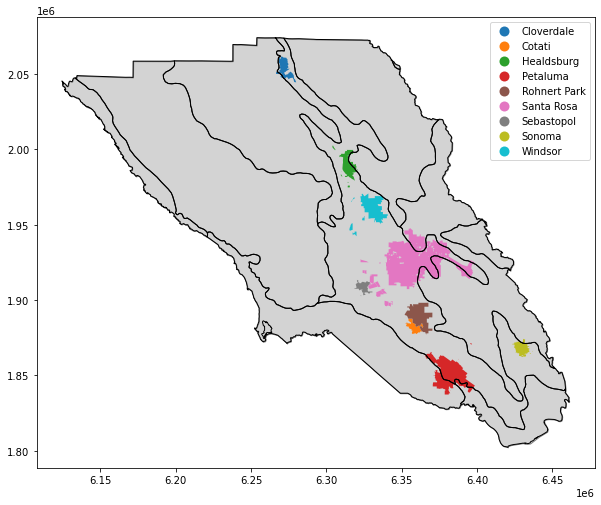

In [22]:
# Incorporated cities
fig, ax = plt.subplots(figsize=(10,10))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "#D3D3D3")
cities.plot(ax=ax, column = "CITY_NAME", legend = True)
ecoregions_simp.plot(ax=ax, color = "None")

In [32]:
# intersect cities with ecoregions 
inc_cities_zones = gpd.overlay(cities, ecoregions_simp, how='intersection')

In [35]:
# simplify
inc_cities_zones_simp = inc_cities_zones[["l4_simple", "FULL_NAME"]]
inc_cities_zones_simp = inc_cities_zones_simp.rename(columns = {'l4_simple': 'ecoregion', 'FULL_NAME': 'city_name'})
inc_cities_zones_simp.head()

,ecoregion,city_name
0,Napa-Sonoma-Russian River Valleys,City of Cotati
1,Napa-Sonoma-Russian River Valleys,City of Sonoma
2,Napa-Sonoma-Russian River Valleys,Town of Windsor
3,Napa-Sonoma-Russian River Valleys,City of Healdsburg
4,Napa-Sonoma-Russian River Valleys,City of Sebastopol


<AxesSubplot:>

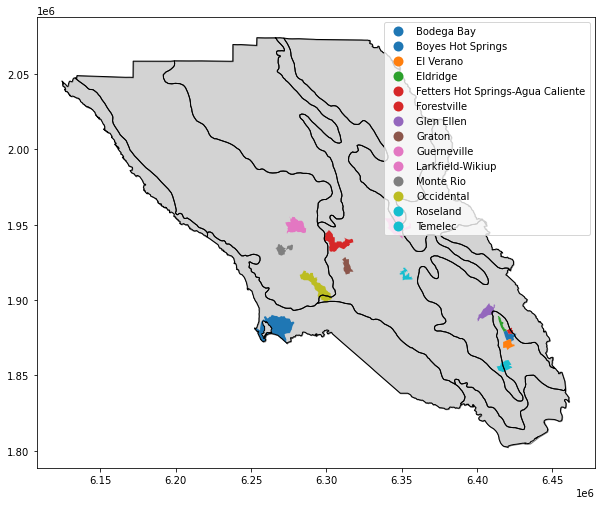

In [29]:
# unincorporated cities
fig, ax = plt.subplots(figsize=(10,10))
soco_bound.plot(ax=ax, edgecolor = "grey", color = "#D3D3D3")
soco_unincorp_cities.plot(ax=ax, column = "NAME", legend = True)
ecoregions_simp.plot(ax=ax, color = "None")

In [36]:
uninc_cities_zones = gpd.overlay(soco_unincorp_cities, ecoregions_simp, how='intersection')

In [38]:
# simplify
uninc_cities_zones_simp = uninc_cities_zones[["l4_simple", "NAME"]]
uninc_cities_zones_simp = uninc_cities_zones_simp.rename(columns = {'l4_simple': 'ecoregion', 'NAME': 'city_name'})
uninc_cities_zones_simp.head()

,ecoregion,city_name
0,Bodega Coastal Hills,Bodega Bay
1,Napa-Sonoma-Lake Volcanic Highlands,Boyes Hot Springs
2,Napa-Sonoma-Lake Volcanic Highlands,Fetters Hot Springs-Agua Caliente
3,Napa-Sonoma-Lake Volcanic Highlands,Glen Ellen
4,Napa-Sonoma-Lake Volcanic Highlands,Larkfield-Wikiup


In [42]:
# combine into one csv
all_cities_zones = pd.concat([inc_cities_zones_simp, uninc_cities_zones_simp])
all_cities_zones.head()

,ecoregion,city_name
0,Napa-Sonoma-Russian River Valleys,City of Cotati
1,Napa-Sonoma-Russian River Valleys,City of Sonoma
2,Napa-Sonoma-Russian River Valleys,Town of Windsor
3,Napa-Sonoma-Russian River Valleys,City of Healdsburg
4,Napa-Sonoma-Russian River Valleys,City of Sebastopol


In [43]:
# export to csv
all_cities_zones.to_csv(clean_data + "ecoregion_cities.csv")

#### Zoning

In [ ]:
# dissolve by district
zones_simp = zoning.dissolve(by = "DISTRICT").reset_index()
zones_simp = zones_simp[["DISTRICT", "geometry"]]

In [14]:
# intersect with ecoregions and calculate areas
zones_zoning = util.zone_intersect(zones_simp, ecoregions_simp, 'acres')
zones_zoning['percent_of_ecoregion'] = zones_zoning['acres'] / zones_zoning['ecoregion_acres'] * 100
zones_zoning = zones_zoning.rename(columns = {'l4_simple': 'ecoregion'})
zones_zoning = zones_zoning[["ecoregion", "DISTRICT", "acres", "percent_of_ecoregion"]]
zones_zoning.head()


,ecoregion,DISTRICT,acres,percent_of_ecoregion
0,Bodega Coastal Hills,AR,8369.964676,9.320931
1,Bodega Coastal Hills,AS,7.369339,0.008207
2,Bodega Coastal Hills,C1,9.007817,0.010031
3,Bodega Coastal Hills,C3,3.874501,0.004315
4,Bodega Coastal Hills,CF,30.896584,0.034407


In [15]:
# save to files
zones_zoning.to_csv(clean_data + "zoning_stats.csv")

#### Critical Facilities

In [20]:
# intersect ecoregions and critical facilities to see which ecoregion the critical facilities are in
critical_facilities = critical_facilities.to_crs(2226)
critical_facil_zones = gpd.overlay(critical_facilities, ecoregions_simp, how='intersection')

In [30]:
critical_facil_zones_simp = critical_facil_zones[["Haz_Facili", "Haz_Catego", "Haz_Type", "Haz_City", "l4_simple", "geometry"]]
critical_facil_zones_simp.head()

,Haz_Facili,Haz_Catego,Haz_Type,Haz_City,l4_simple,geometry
0,PETALUMA MUNICIPAL AIRPORT,Transportation,Airport,Petaluma,Napa-Sonoma-Russian River Valleys,POINT Z (6387793.875 1855692.532 0.000)
1,HEALDSBURG MUNICIPAL AIRPORT,Transportation,Airport,Healdsburg,Napa-Sonoma-Russian River Valleys,POINT Z (6304657.671 2000859.234 0.000)
2,CLOVERDALE MUNICIPAL AIRPORT,Transportation,Airport,Cloverdale,Napa-Sonoma-Russian River Valleys,POINT Z (6278817.609 2045115.571 0.000)
3,SONOMA SKYPARK AIRPORT,Transportation,Airport,Unincorporated,Napa-Sonoma-Russian River Valleys,POINT Z (6436162.972 1856688.921 0.000)
4,SONOMA VALLEY AIRPORT,Transportation,Airport,Unincorporated,Napa-Sonoma-Russian River Valleys,POINT Z (6431036.909 1843684.705 0.000)


In [31]:
critical_facil_zones_stats = critical_facil_zones_simp.groupby(["l4_simple", "Haz_Catego"]).size().reset_index(name='counts')
critical_facil_zones_stats.head(10)

,l4_simple,Haz_Catego,counts
0,Bay Flats,Communication,1
1,Bay Flats,Energy,1
2,Bay Flats,"Food, Water, Shelter",3
3,Bay Flats,Hazardous Material,99
4,Bay Flats,Safety and Security,3
5,Bay Flats,Transportation,7
6,Bodega Coastal Hills,Communication,8
7,Bodega Coastal Hills,Energy,2
8,Bodega Coastal Hills,"Food, Water, Shelter",11
9,Bodega Coastal Hills,Hazardous Material,206


In [32]:
# export to csv
critical_facil_zones_stats.to_csv(clean_data + "critical_facilities_stats.csv")